In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scanimagetiffio import SITiffIO
#import utils_image from the parent folder
import sys
sys.path.append("..")
from utils_image import get_meanZstack, UnrotateCropFrame, RegFrame, compute_zpos_sp, findFOV
import suite2p
from suite2p.registration import utils

In [4]:
datafolder = '/home/zilong/Desktop/2D2P/Data/183_28072023/'
# read the rotation center from the circlecenter txt file
circlecenterfilename = datafolder+"DP_exp/circlecenter.txt"
with open(circlecenterfilename, "r") as f:
    # read the last row
    last_line = f.readlines()[-1]
    # assign the x and y coordinates to self.rotx and self.roty
    rotx = float(last_line.split()[0])
    roty = float(last_line.split()[1])
print("Rotation center is at ({}, {})".format(rotx, roty))

Rotation center is at (268.0, 253.0)


In [3]:
#load the zstack tiff and calculate the mean frames for each stack
zstacktiff = datafolder + 'stack28072023_00005.tif'
zstackrelog = datafolder + 'REdata_20230728_190540.stack00005.txt'

volume = 1; stacks=71; frames=200; Rotcenter=[rotx, roty]; ImgReg=True

#load the zstack data
S = SITiffIO()
S.open_tiff_file(zstacktiff, "r")
S.open_rotary_file(zstackrelog)
S.interp_times() 
#get the mean frames for each stack
meanZ = get_meanZstack(S, volume, stacks, frames, Rotcenter, ImgReg)

#save the meanZ as a npy file
np.save(datafolder + 'DP/fullZ.npy', meanZ)


Loading rotary encoder file: /home/zilong/Desktop/2D2P/Data/183_28072023/REdata_20230728_190540.stack00005.txt
Finished calculating rotations and times.
The rotary encoder file has 61769 timestamps in it.
Counted 14200 frames
Extract the mean frame of Zstacks...
Processing stack 0
Reference frame, 4.28 sec.
Registered 200/200 in 3.66s
Processing stack 1
Reference frame, 4.31 sec.
Registered 200/200 in 3.63s
Processing stack 2
Reference frame, 4.19 sec.
Registered 200/200 in 3.57s
Processing stack 3
Reference frame, 4.33 sec.
Registered 200/200 in 3.66s
Processing stack 4
Reference frame, 4.22 sec.
Registered 200/200 in 3.68s
Processing stack 5
Reference frame, 4.29 sec.
Registered 200/200 in 3.64s
Processing stack 6
Reference frame, 4.28 sec.
Registered 200/200 in 3.64s
Processing stack 7
Reference frame, 4.29 sec.
Registered 200/200 in 3.61s
Processing stack 8
Reference frame, 4.26 sec.
Registered 200/200 in 3.65s
Processing stack 9
Reference frame, 4.25 sec.
Registered 200/200 in 3.7

In [68]:
np.save(datafolder + 'DP/fullZ.npy', meanZ)

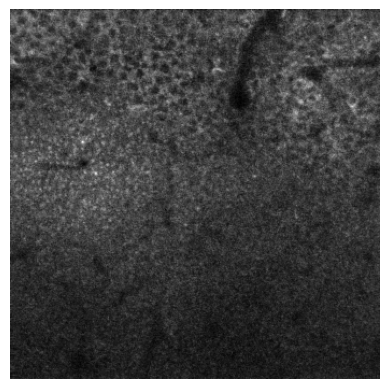

In [5]:
#visualize 
if not os.path.exists(datafolder+'meanZstacksreg'):
    os.makedirs(datafolder+'meanZstacksreg')
for i in range(meanZ.shape[0]):
    frame_i = meanZ[i,:,:]
    plt.imshow(frame_i, cmap='gray')
    plt.axis('off')
    plt.savefig(datafolder+'meanZstacksreg/'+'stack'+str(i+1)+'.png')

Loading rotary encoder file: /home/zilong/Desktop/2D2P/Data/183_28072023/REdata_20230728_171614.00003.txt
Calculating rotations and times from rotary encoder data...
Finished calculating rotations and times.
The rotary encoder file has 34589 timestamps in it.
Counted 9000 frames
Reference frame, 6.62 sec.
Registered 200/1000 in 3.96s
Registered 400/1000 in 7.94s
Registered 600/1000 in 11.97s
Registered 800/1000 in 15.99s
Registered 1000/1000 in 20.03s


(-0.5, 343.5, 343.5, -0.5)

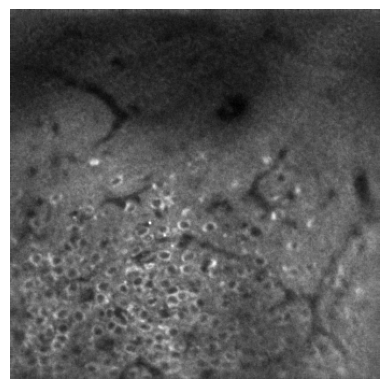

In [6]:
# load the imaging tiff and read the last 1000 frames and get the mean frame
#load the imaging tiff 
imagingtiff = datafolder+'28072023_00003.tif'
imagingrelog = datafolder+'REdata_20230728_171614.00003.txt'

S = SITiffIO()
S.open_tiff_file(imagingtiff, "r")
S.open_rotary_file(imagingrelog)
#extract the last self.numFrames frames from the tiff file
tailArray, tailAng = S.tail(1000)
        
# unrotate each frame in the tiff file with the detected rotation center
unrotFrames  = UnrotateCropFrame(tailArray, tailAng, Rotcenter)

#perform image registraion
meanRegImg, _ = RegFrame(unrotFrames)

#visual the meanRegImg
plt.imshow(meanRegImg, cmap='gray')
plt.axis('off')

In [7]:
#run phase correlation between meanZ and the meanRegImg
ops = suite2p.default_ops()

meanRegImg = meanRegImg[np.newaxis, :, :]

#get the last two dimension the meanZ and meanRegImg
_, wZ, hZ = meanZ.shape
_, wReg, hReg = meanRegImg.shape
if wReg>wZ:
    #cut the meanRegImg to the same size as meanZ
    meanRegImg = meanRegImg[:, -wZ:, -hZ:]
elif wReg<wZ:
    #center pad each edge of meanRegImg to the same size as meanZ
    wpad = (wZ-wReg)//2
    hpad = (hZ-hReg)//2
    meanRegImg = np.pad(meanRegImg, ((0,0), (wpad, wpad), (hpad, hpad)), mode="constant", constant_values=0)
else:
    pass

#calculate the phase correlation between meanZ and meanRegImg
#return the x and y shift and zcorr
ymax, xmax, zcorr = compute_zpos_sp(meanZ, meanRegImg, ops)



1 planes, 0/1 frames, 0.00 sec.
11 planes, 0/1 frames, 0.02 sec.
21 planes, 0/1 frames, 0.04 sec.
31 planes, 0/1 frames, 0.06 sec.
41 planes, 0/1 frames, 0.08 sec.
51 planes, 0/1 frames, 0.10 sec.
61 planes, 0/1 frames, 0.12 sec.
70 planes, 0/1 frames, 0.13 sec.


Text(13, [0.0141928], 'maxZplane=13\nshift (y,x) = (-7,-10)')

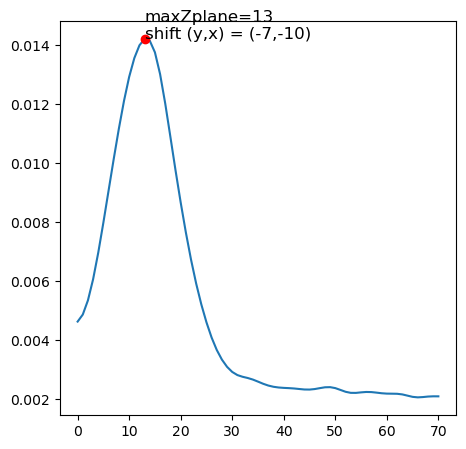

In [24]:
#apply gaussian filter to zcorr
zcorr_gs = gaussian_filter1d(zcorr.copy(), 2, axis=0)
#get the max index of zcorr
maxcorr_ind = np.argmax(zcorr_gs)
#get the ymax and xmax shift from zcorr with max index
ymax_shift = ymax[maxcorr_ind][0]
xmax_shift = xmax[maxcorr_ind][0]  

#plot zcorr with curve
plt.figure(figsize=(512/100,512/100),dpi=100)
plt.plot(zcorr_gs)
#add a red point to indicate the max index
plt.plot(maxcorr_ind, zcorr_gs[maxcorr_ind], 'ro')
#add text to indicate the max index beside the red point, as well as the ymax and xmax shift values
plt.text(maxcorr_ind, zcorr_gs[maxcorr_ind], 'maxZplane='+ str(maxcorr_ind)+'\nshift (y,x) = (' + str(ymax_shift) +',' + str(xmax_shift)+')', fontsize=12)

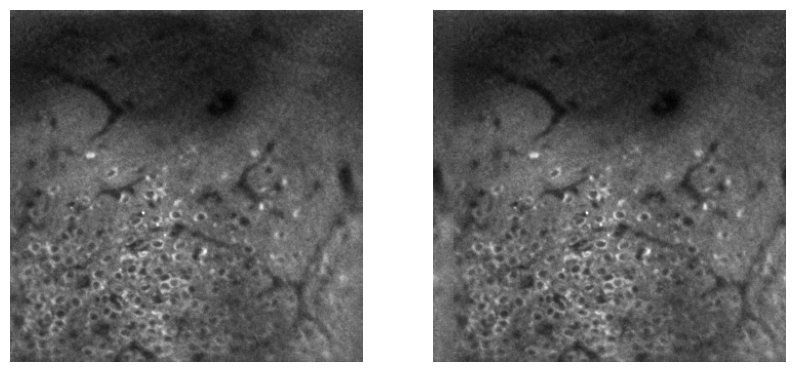

In [29]:
#artificially move the meanRegImg to the right for 20 pixels
meanRegImg_roll = np.roll(meanRegImg, 20, axis=2)
#visualize the meanRegImg and the meanRegImg_roll in the same figure
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(meanRegImg[0], cmap='gray')
ax[0].axis('off')
ax[1].imshow(meanRegImg_roll[0], cmap='gray')
ax[1].axis('off')
plt.show()

1 planes, 0/1 frames, 0.00 sec.
11 planes, 0/1 frames, 0.02 sec.
21 planes, 0/1 frames, 0.04 sec.
31 planes, 0/1 frames, 0.06 sec.
41 planes, 0/1 frames, 0.08 sec.
51 planes, 0/1 frames, 0.10 sec.
61 planes, 0/1 frames, 0.11 sec.
70 planes, 0/1 frames, 0.13 sec.


Text(13, [0.01452505], 'maxZplane=13\nshift (y,x) = (-6,10)')

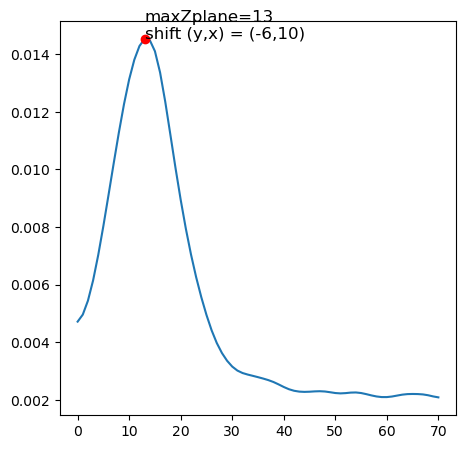

In [30]:
#calculate the phase correlation between meanZ and meanRegImg
#return the x and y shift and zcorr
ymax, xmax, zcorr = compute_zpos_sp(meanZ, meanRegImg_roll, ops)

#apply gaussian filter to zcorr
zcorr_gs = gaussian_filter1d(zcorr.copy(), 2, axis=0)
#get the max index of zcorr
maxcorr_ind = np.argmax(zcorr_gs)
#get the ymax and xmax shift from zcorr with max index
ymax_shift = ymax[maxcorr_ind][0]
xmax_shift = xmax[maxcorr_ind][0]  

#plot zcorr with curve
plt.figure(figsize=(512/100,512/100),dpi=100)
plt.plot(zcorr_gs)
#add a red point to indicate the max index
plt.plot(maxcorr_ind, zcorr_gs[maxcorr_ind], 'ro')
#add text to indicate the max index beside the red point, as well as the ymax and xmax shift values
plt.text(maxcorr_ind, zcorr_gs[maxcorr_ind], 'maxZplane='+ str(maxcorr_ind)+'\nshift (y,x) = (' + str(ymax_shift) +',' + str(xmax_shift)+')', fontsize=12)

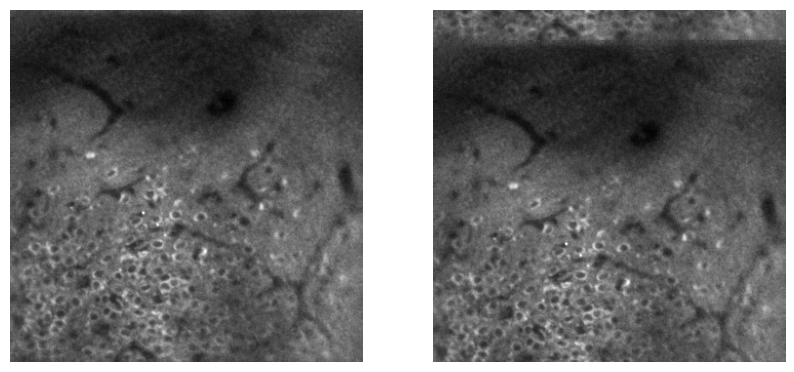

In [32]:
#artificially move the meanRegImg to the right for 20 pixels
meanRegImg_roll2 = np.roll(meanRegImg, 30, axis=1)
#visualize the meanRegImg and the meanRegImg_roll in the same figure
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(meanRegImg[0], cmap='gray')
ax[0].axis('off')
ax[1].imshow(meanRegImg_roll2[0], cmap='gray')
ax[1].axis('off')
plt.show()

1 planes, 0/1 frames, 0.00 sec.
11 planes, 0/1 frames, 0.02 sec.
21 planes, 0/1 frames, 0.04 sec.
31 planes, 0/1 frames, 0.06 sec.
41 planes, 0/1 frames, 0.08 sec.
51 planes, 0/1 frames, 0.10 sec.
61 planes, 0/1 frames, 0.12 sec.
70 planes, 0/1 frames, 0.13 sec.


Text(13, [0.01451283], 'maxZplane=13\nshift (y,x) = (24,-10)')

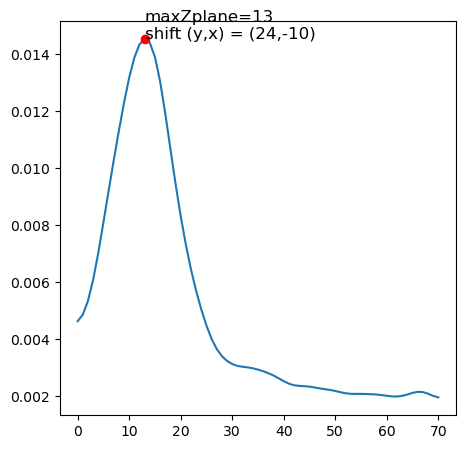

In [33]:
#calculate the phase correlation between meanZ and meanRegImg
#return the x and y shift and zcorr
ymax, xmax, zcorr = compute_zpos_sp(meanZ, meanRegImg_roll2, ops)

#apply gaussian filter to zcorr
zcorr_gs = gaussian_filter1d(zcorr.copy(), 2, axis=0)
#get the max index of zcorr
maxcorr_ind = np.argmax(zcorr_gs)
#get the ymax and xmax shift from zcorr with max index
ymax_shift = ymax[maxcorr_ind][0]
xmax_shift = xmax[maxcorr_ind][0]  

#plot zcorr with curve
plt.figure(figsize=(512/100,512/100),dpi=100)
plt.plot(zcorr_gs)
#add a red point to indicate the max index
plt.plot(maxcorr_ind, zcorr_gs[maxcorr_ind], 'ro')
#add text to indicate the max index beside the red point, as well as the ymax and xmax shift values
plt.text(maxcorr_ind, zcorr_gs[maxcorr_ind], 'maxZplane='+ str(maxcorr_ind)+'\nshift (y,x) = (' + str(ymax_shift) +',' + str(xmax_shift)+')', fontsize=12)

(61, 344, 344)

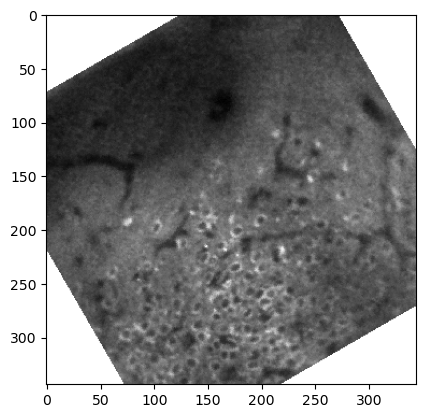

In [65]:
from PIL import Image
#rotate the meanRegImg from -30 degree to 30 degree with 1 degree step with the image center
meanRegImg_ = meanRegImg[0]
#int16
meanRegImg_ = meanRegImg_.astype("int16")
#get center
center = (meanRegImg_.shape[1]//2, meanRegImg_.shape[0]//2)

#create an empty array to store the rotated images
rotImgs = np.zeros((61, meanRegImg_.shape[0], meanRegImg_.shape[1]))
for i, ang in enumerate(range(-30, 31, 1)):
    rotImg = Image.fromarray(meanRegImg_).rotate(ang)
    rotImg = np.array(rotImg)
    #save
    rotImgs[i] = rotImg
    
#compute the mean of the rotated images
meanRotImg = np.mean(rotImgs, axis=0)
#visualize
plt.imshow(rotImgs[-1], cmap="gray")


In [66]:
rotImgs

#calculate the phase correlation between meanZ and meanRegImg
#return the x and y shift and zcorr
ymax, xmax, zcorr = compute_zpos_sp(meanZ, rotImgs, ops)
#gaussian filter the zcorr
zcorr = gaussian_filter1d(zcorr.copy(), 2, axis=0)

1 planes, 0/61 frames, 0.29 sec.
11 planes, 0/61 frames, 1.72 sec.
21 planes, 0/61 frames, 3.16 sec.
31 planes, 0/61 frames, 4.58 sec.
41 planes, 0/61 frames, 6.00 sec.
51 planes, 0/61 frames, 7.69 sec.
61 planes, 0/61 frames, 9.19 sec.
70 planes, 0/61 frames, 10.67 sec.


Text(0, 0.5, 'stack index')

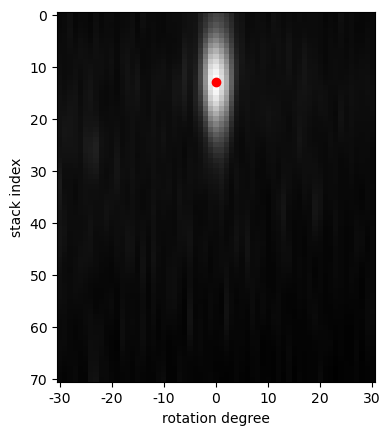

In [71]:
zcorr = gaussian_filter1d(zcorr.copy(), 2, axis=0)
#visulize zcorr
plt.imshow(zcorr, cmap='gray')

#find the max value in zcorr and mark it with a red dot
maxvalue = np.max(zcorr)
maxindex = np.where(zcorr == maxvalue)
plt.plot(maxindex[1], maxindex[0], 'ro')

#relabel x label from -30 to 30
plt.xticks(np.arange(0, 61, 10), np.arange(-30, 31, 10))


plt.xlabel('rotation degree')
plt.ylabel('stack index')


In [11]:
datafolder = '/home/zilong/Desktop/2D2P/Data/183_28072023/'

#load zstacks
zstacks = np.load('/home/zilong/Desktop/2D2P/Data/183_28072023/DP/fullZ.npy')

# load the imaging tiff and read the last 1000 frames and get the mean frame
imagingtiff = datafolder+'28072023_00004.tif'
imagingrelog = datafolder+'REdata_20230728_172315.00004.txt'
S = SITiffIO()
S.open_tiff_file(imagingtiff, "r")
S.open_rotary_file(imagingrelog)
#extract the last self.numFrames frames from the tiff file
tailArray, tailAng = S.tail(1000)   
# unrotate each frame in the tiff file with the detected rotation center
Rotcenter = [rotx, roty]
unrotFrames  = UnrotateCropFrame(tailArray, tailAng, Rotcenter)
#perform image registraion
meanRegImg, _ = RegFrame(unrotFrames)




Loading rotary encoder file: /home/zilong/Desktop/2D2P/Data/183_28072023/REdata_20230728_172315.00004.txt
Calculating rotations and times from rotary encoder data...
Finished calculating rotations and times.
The rotary encoder file has 35643 timestamps in it.
Counted 9000 frames
Reference frame, 7.78 sec.
Registered 200/1000 in 4.63s
Registered 400/1000 in 8.83s
Registered 600/1000 in 13.00s
Registered 800/1000 in 17.17s
Registered 1000/1000 in 21.37s


In [12]:
ymax, xmax, zcorr = findFOV(zstacks, meanRegImg, maxrotangle=30)

1 planes, 0/61 frames, 0.42 sec.
11 planes, 0/61 frames, 2.22 sec.
21 planes, 0/61 frames, 4.04 sec.
31 planes, 0/61 frames, 5.87 sec.
41 planes, 0/61 frames, 8.18 sec.
51 planes, 0/61 frames, 10.01 sec.
61 planes, 0/61 frames, 11.74 sec.
70 planes, 0/61 frames, 13.30 sec.


In [13]:
zcorr_gs = gaussian_filter1d(zcorr.copy(), 2, axis=0)
maxvalue = np.max(zcorr_gs)
maxindex = np.where(zcorr_gs == maxvalue)
maxindex


(array([12]), array([30]))

In [14]:
stack_ind = maxindex[0][0]

In [15]:
zstacks[stack_ind]

array([[-907., -898., -868., ..., -917., -918., -882.],
       [-876., -871., -852., ..., -885., -878., -887.],
       [-901., -881., -871., ..., -880., -889., -875.],
       ...,
       [-921., -934., -925., ..., -934., -937., -938.],
       [-939., -926., -914., ..., -939., -948., -955.],
       [-917., -902., -911., ..., -947., -951., -948.]])